# <h1 style='background:red; border:0; border-radius: 10px; color:black'><center> INTRODUCTION </center></h1>
## **What is a Time Series??**⏲📈

- **Time-series is series of obeservations that are recorded over a period of time. these observations are dependent of time component which can not be neglected thus we have have to analysis the this data keeping time component in mind.**

<img src = "https://miro.medium.com/max/1400/0*j8LjgYr1r1xPrJkr.gif" width = 900 height = 400/>

### **Time Series Forecasting**

<div class="alert alert-block alert-info">
    
Time series forecasting is perhaps one of the most common type of machine learning techniques used in real-world scenarios. `time-sereis forecsting refers to predicting future values from historical data by statical analysis of trends and patterns from certain time-series data.` it falls under unsupervised learning category but called as a self-supervised learning or supervised learning technique. time-series data can be much complex to find patterns out of it, this is because irregular component of time series.
</div>

## **Use-cases and applications:**
- Forecast product demand
- Economic growth and population forecasting
- Weather forecasting
- Stock price forecasting
- Sales/Revenue forecasting
- Web-traffic forecasting


## **Problem-statement**

- In this notebook, our problem-statement is to analyse S&P500 stock prices (We will analyze 10 popular stocks and forecast the future prices) and build forecasting models that beat the market.


## Table of contents:

**1) [Importing libraries](#lib)**

**2) [Data analysis and visualizations](#viz)**

   - **[Data cleaning](#cln)**
   - **[What are the TOP 10 most traded stocks?](#top10)**
   - **[Closing stock price visualization and what was the maximum price?](#close)**
   - **[What was the trade volume during period of 2013-18?](#trade)**
   - **[Comparative analysis of tech stocks](#tech)**
   - **[Growth of stock price over a period of 2013-18](#growth)**
   - **[Daily return of stock price analysis and hypothesis testing](#dr)**
   
**3) [Technical analysis of stocks using candle stick charts and Moving average](#ta)**

   - **[Candlestick stock charts to visualize OHLC prices](#candle)**
   - **[Moving average charts of 'FB' and 'AAPL'. which stock performed better?](#mav)**
   
**4) [Stock price forecasting: Modeling & forecasts](#forecast)**
  
   - **[Forecasting using Prophet](#prop)**
   - **[Forecasting using Auto-ARIMA Models](#arima)**

# <h1 style='background:green; border:0; border-radius: 10px; color:black'><center> Importing Libraries</center></h1>

<a id='lib'></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from scipy import stats
import matplotlib.dates as mdates
from plotly import tools
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

init_notebook_mode(connected=True)
%matplotlib inline
# matplotlib defaults
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install mplfinance

In [ ]:
!pip install pystan==2.19.1.1
!pip install fbprophet

In [ ]:
!pip install pmdarima

In [ ]:
import mplfinance as mpf
from fbprophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

# <h1 style='background:red; border:0; border-radius: 10px; color:black'><center> Data analysis and visualizations </center></h1>

In [ ]:
# read the dataframe
df = pd.read_csv("../input/sandp500/all_stocks_5yr.csv")
df.head().style.set_properties(**{'background-color': 'black',
                                    'color': 'lawngreen',
                                    'border': '1.5px  white'})

In [ ]:
# define simple function get all the information needed
def information_func(df):
    
    # unique stocks
    print("Uniques stocks available in dataset:", df['Name'].nunique())
    print("----"*20)
    
    # metadata of dataset
    print("Metadata of the dataset:\n")
    df.info()
    print("----"*20)
    
    # missing values
    null = df.isnull().sum()
    print(null)
    print("----"*20)
    
    # max range of stocks dataset
    delta = (pd.to_datetime(df['date']).max() - pd.to_datetime(df['date']).min())
    print("Time range of stocks dataset:\n", delta)
    print("----"*20) 

In [ ]:
information_func(df)

### <h1 style='background:#4bd659; border:0; border-radius: 10px; color:black'><right> Data cleaning </right></h1>

<a id='cln'></a>

In [ ]:
# rename Name to ticks
rdf = df.rename(columns={'Name':'ticks'})

# drop the null as they a few values and time-series won't be affected by such values
rdf.dropna(inplace=True)

# change the dtype of date column
new_df = rdf.copy()
new_df.loc[:, 'date'] = pd.to_datetime(rdf.loc[:, 'date'], format='%Y/%m/%d')

# new dataframe info
new_df.info()

### <h1 style='background:#ed615c; border:0; border-radius: 10px; color:black'><right> Top 10 stock tickers by average trade volume </right></h1>
<a id='top10'></a>

In [ ]:
# find the average volume of each stocks using function and sort top 10 most traded stocks for further analysis 
mean_dict = {}

# find average of volume traded over a period of time using for loops
for key in new_df['ticks'].unique():
    value = new_df[new_df['ticks'] == key ]['volume'].mean()
    mean_dict[key]= value

print("Length of the mean of ticks dictionary:", len(mean_dict))

# convert dict to pandas dataframe
avaerage_s = pd.Series(mean_dict).transpose()
top10_s = avaerage_s.sort_values(ascending=False)[:10]

print("Top 10 company tickers with highest average traded stock volume:\n", top10_s.index)

In [ ]:
# function to return top 10 sub dataframe
def subdataframe(df, tick):
    
    # top 10 ticks
    ticks = list(top10_s.index)
    
    assert tick in ticks, """Stock tick does not belong to top 10 stocks by trade volume, please try any of these:\n
    ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']"""
    
    ndf = new_df[new_df['ticks'] == tick]
    return ndf

In [ ]:
# company dict for respective ticks (TOP 10 STOCKS BY AVERAGE TRAE VOLUME)
company_dict = {'BAC':'Bank of America', 
                'AAPL':'Apple', 
                'GE':'General Electric', 
                'F':'Ford Motor Company', 
                'FB':'Facebook', 
                'MSFT':'Microsoft', 
                'AMD':'Adavanced Micro Devices', 
                'MU':'Micron Technology', 
                'INTC':'Intel Corp', 
                'CSCO':'Cisco'
               }

bac_df = subdataframe(new_df, 'BAC')
aapl_df = subdataframe(new_df, 'AAPL')
ge_df = subdataframe(new_df, 'GE')
f_df = subdataframe(new_df, 'F')
fb_df = subdataframe(new_df, 'FB')
msft_df = subdataframe(new_df, 'MSFT')
amd_df = subdataframe(new_df, 'AMD')
mu_df = subdataframe(new_df, 'MU')
intc_df = subdataframe(new_df, 'INTC')
csco_df = subdataframe(new_df, 'CSCO')


# define a function to return daily return and company column
def dailyfunc(df):
    df['daily return'] = ((df['close'] - df['open'])/df['open'])*100
    df.style.format('{:.2f}%', subset='daily return')
    df['daily_mean'] = (df['open'] + df['close'] + df['high'] + df['low'])/4
    df['co_name'] = company_dict[df['ticks'].unique()[0]]
    return df

bac_df = dailyfunc(bac_df)
aapl_df = dailyfunc(aapl_df)
ge_df = dailyfunc(ge_df)
f_df = dailyfunc(f_df)
fb_df = dailyfunc(fb_df)
msft_df = dailyfunc(msft_df)
amd_df = dailyfunc(amd_df)
mu_df = dailyfunc(mu_df)
intc_df = dailyfunc(intc_df)
csco_df = dailyfunc(csco_df)

print('\t\tStart Date\t\t\t\t\tEnd Date')
print(f"BAC\t\t{bac_df['date'].min()}\t\t\t{bac_df['date'].max()}")
print(f"AAPL\t\t{aapl_df['date'].min()}\t\t\t{aapl_df['date'].max()}")
print(f"GE\t\t{ge_df['date'].min()}\t\t\t{ge_df['date'].max()}")
print(f"F\t\t{f_df['date'].min()}\t\t\t{f_df['date'].max()}")
print(f"FB\t\t{fb_df['date'].min()}\t\t\t{fb_df['date'].max()}")
print(f"MSFT\t\t{msft_df['date'].min()}\t\t\t{msft_df['date'].max()}")
print(f"AMD\t\t{amd_df['date'].min()}\t\t\t{amd_df['date'].max()}")
print(f"MU\t\t{mu_df['date'].min()}\t\t\t{mu_df['date'].max()}")
print(f"INTC\t\t{intc_df['date'].min()}\t\t\t{intc_df['date'].max()}")
print(f"CSCO\t\t{csco_df['date'].min()}\t\t\t{csco_df['date'].max()}")

### <h1 style='background:#4bd659; border:0; border-radius: 10px; color:black'><right> Closing stock price visualizations & maximum price during 5 years </right></h1>  
<a id='close'></a>

In [ ]:
# function return closing stock price over a 5 years of time period
def closing_stock_price(df):
    
    # define highest stock over 5 period of time with date of the same
    high = df['close'].max()
    datetime = df[df['close'] == df['close'].max()]['date'].values
    
    if df['ticks'].unique()[0] == 'GE':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    elif df['ticks'].unique()[0] == 'F':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    else:
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['close'], color='#0f2113')
    ax.set_title(f"{df['co_name'].unique()[0]} stock price", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily closing stock price", fontsize=15)
    if df['ticks'].unique()[0] == 'AAPL':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-35),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'F':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-3),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'FB':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-50),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MSFT':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-20),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MU':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-15),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    else:
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-10),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))

    plt.show()
    
# plot of all the closing stocks
closing_stock_price(bac_df)
closing_stock_price(aapl_df)
closing_stock_price(ge_df)
closing_stock_price(f_df)
closing_stock_price(fb_df)
closing_stock_price(msft_df)
closing_stock_price(amd_df)
closing_stock_price(mu_df)
closing_stock_price(intc_df)
closing_stock_price(csco_df)

**Key findings:**
    
- **We could find TOP 10 most traded stocks duing period of 2013-2018.**
- **Out of 10 companies one is bank, 7 of them are tech companies, another two are non-tech lagacy companies namely General electric and Ford motors.**
- **From closing stock price visualization, we can learn that stocks 'GE' and 'F' are declining and other tech stocks are rising over a five year period time.**
- **As we can see visualizations are self-explanatory and we can learn all time high stock prices of all the tickers.**

### **Lifecycle of companies and products:**

- We can observe from above plots that stock prices of companies like FORD and GE are declining while teck companies' stocks are rising rapidly. this indicates course or lifecycle of companies.
- In below image one can observe the lifecycle of any company or product from startup phase to decline stage. this is the most general theory in business that typical companies  follow such cycles.
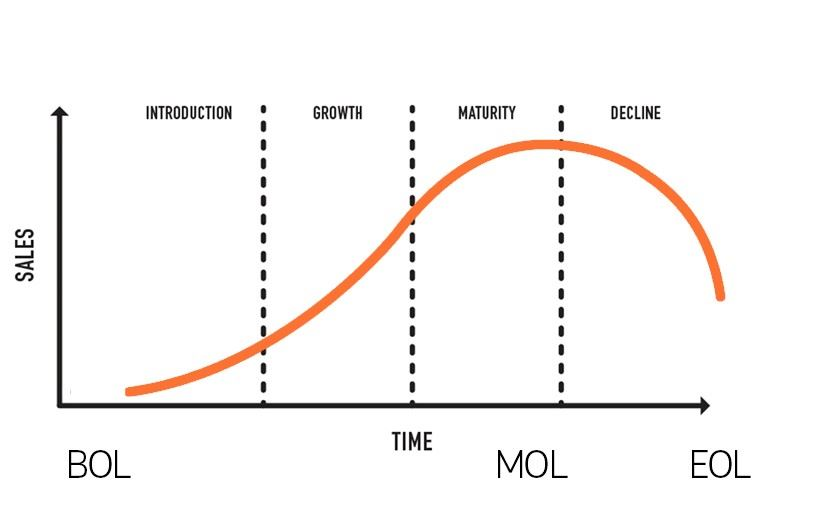

### <h1 style='background:#ed615c; border:0; border-radius: 10px; color:black'><right> Trade volume of stocks over a period of 2013-2018 </right></h1>
<a id='trade'></a>

In [ ]:
# function to visualize trade volume of stocks
def trade_vol(df):
    
    # x and y coords for average trade volume
    ave_x = df['date'].mean()
    ave_y = df['volume'].mean()
    # y coord for max trade vol
    max_y = df['volume'].max()
    # y coord for min trade vol
    min_y = df['volume'].min()
    
    fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['volume'], color='#283954')
    ax.set_title(f"{df['co_name'].unique()[0]} stock trade volume", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily trade volume", fontsize=15)
    ax.axhline(y=df['volume'].max(), linestyle='--', lw=2.2, color='green')
    ax.axhline(y=df['volume'].min(), linestyle='--',lw=2.2, color='red')
    ax.axhline(y=df['volume'].mean(), linestyle='--',lw=2.8, color='yellow')
    ax.axvline(x=df[df['volume'] == max_y]['date'].values, ls='--', lw='2.2', color='#0aebff')
    ax.annotate(f"Average trade volume {round(df['volume'].mean(),2)}", 
                xy=(ave_x,ave_y),xytext=(ave_x,ave_y + 10000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Maximum trade volume {df['volume'].max()}", 
                xy=(ave_x,max_y),xytext=(ave_x,max_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Minimum trade volume {df['volume'].min()}", 
                xy=(ave_x,min_y),xytext=(ave_x,min_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    
    plt.show()
    

# plot of all stocks trade volume
trade_vol(bac_df)
trade_vol(aapl_df)
trade_vol(ge_df)
trade_vol(f_df)
trade_vol(fb_df)
trade_vol(msft_df)
trade_vol(amd_df)
trade_vol(mu_df)
trade_vol(intc_df)
trade_vol(csco_df)

**Observations:**

- **Above visualizations depicts what was the maximum, minimum and average trade volume overa period of 2013-2018.**
- **As visualizations are self-explanatory in nature we can also learn variance of trade volume for example stock ticker 'INTC' has a higest variance in trade volume compared other tickers.**

### <h1 style='background:#4bd659; border:0; border-radius: 10px; color:black'><right> Comparative analysis of 7 tech stocks </right></h1>  
<a id='tech'></a>

### What is comparative analysis of stocks in finance and investment industry?

- **An important aspect of the fundamental analysis of stocks is comparing stocks of the same sector. The most basic way to analyse and compare stocks from the same sector is to conduct an analysis of different ratios like Earnings per share (EPS), Price-to-Earnings (P/E Ratio), Return on Equity (ROE), Return on Capital Employed (ROCE), and Debt-to-Equity ratios, and stock-prices of various companies, trade volume of stocks.**
- **In this project, due to limited data of companies, we can only compare daily mean stock price of companies and can make inferences like stock price comparison and relative stock price fluctuations that I have mentioned below chart.**

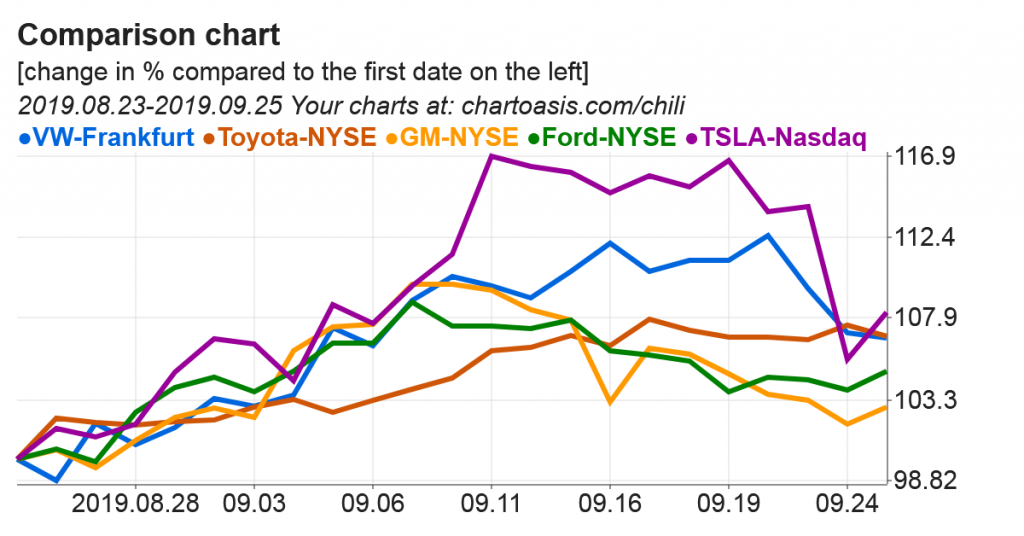

In [ ]:
# tech stocks price comparison
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(fb_df['date'], fb_df['daily_mean'],label='FB', color='#f2f23f', lw=1.4)
ax.plot(aapl_df['date'], aapl_df['daily_mean'],label='AAPL', color='#92f005', lw=1.4)
ax.plot(mu_df['date'], mu_df['daily_mean'],label='MU', color='#f55c0a', lw=1.4)
ax.plot(amd_df['date'], amd_df['daily_mean'],label='AMD', color='#0af5ba', lw=1.4)
ax.plot(intc_df['date'], intc_df['daily_mean'],label='INTC', color='#0a93f5', lw=1.4)
ax.plot(msft_df['date'], msft_df['daily_mean'],label='MSFT', color='#0a29f5', lw=1.4)
ax.plot(csco_df['date'], csco_df['daily_mean'],label='CSCO', color='#c20af5', lw=1.4)
ax.axvspan(*mdates.datestr2num(['2/1/2016','12/31/2017']), color='#e3aaa6')
ax.set_title("Comparative analysis of tech stock prices")
ax.annotate("Years of growth for\nApple,Micron tech and Facebook", xy=(mdates.datestr2num('6/1/2016'),175),
           bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'))
ax.set_xlabel("Date")
ax.set_ylabel("Daily average stock price")
ax.legend(facecolor='#f27985', fontsize="medium", title="Tech stock price analysis", title_fontsize=13)

plt.show()

**Observations**

- **It is very clear that 'FB' stock was one of the most expensive among all 7 tech stocks**
- **stock ticker 'AMD' was among the cheapest to buy compared to other stocks**
- **From above chart we can also conclude that stocks like 'FB' and 'AAPL' were also among the most volatile in nature than other stocks**

### What is volatility?👀📈

> **In finance, volatility (usually denoted by σ) is the degree of variation of a trading price series over time, usually measured by the standard deviation of logarithmic returns.**
> 

*source: wikipedia*

**In layman terms, volatility is nothing but the fluctuation of stock price during given period of time**

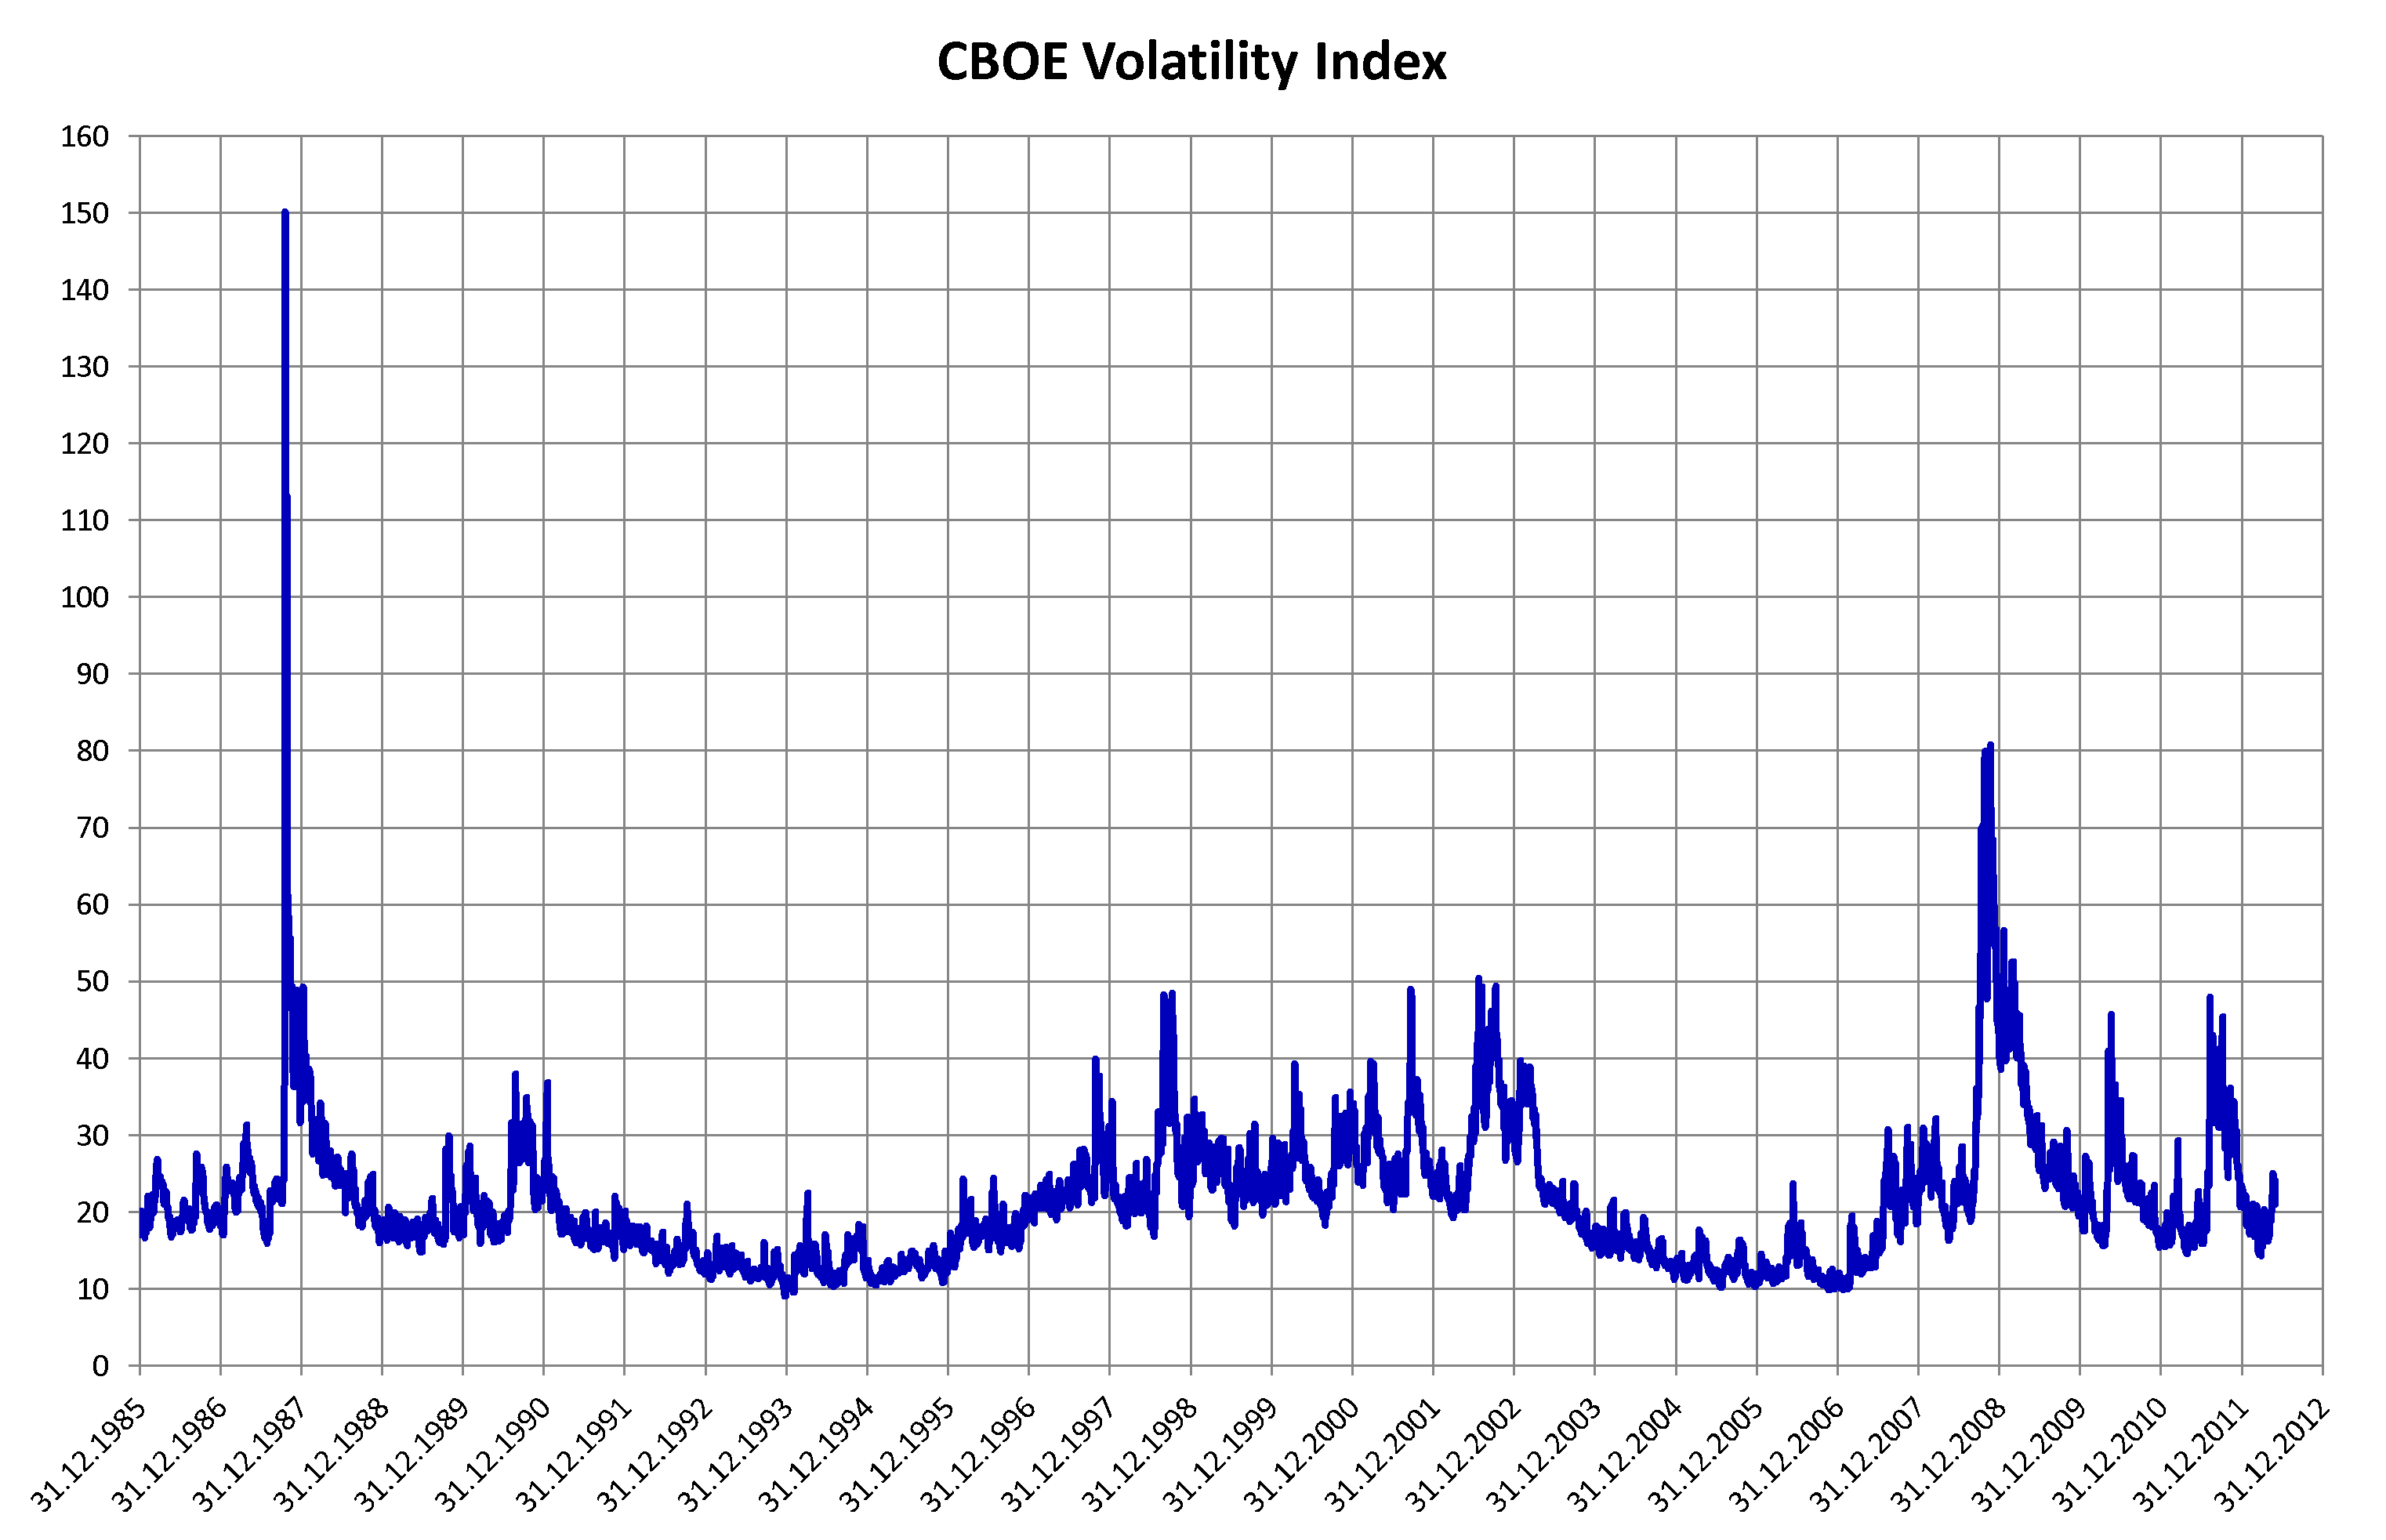

### <h1 style='background:#ed615c; border:0; border-radius: 10px; color:black'><right> Find out growth of stocks of the companies over a 5 years period </right></h1>
<a id='growth'></a>

 ### Growth of stock prices

- **In finance and investment industry, stock price growth is really important metric one needs to measure to find out the how is stock or investment of an individual is growing**
- **Below is the formula to find out growth of stock prices**

*source: educba.com*

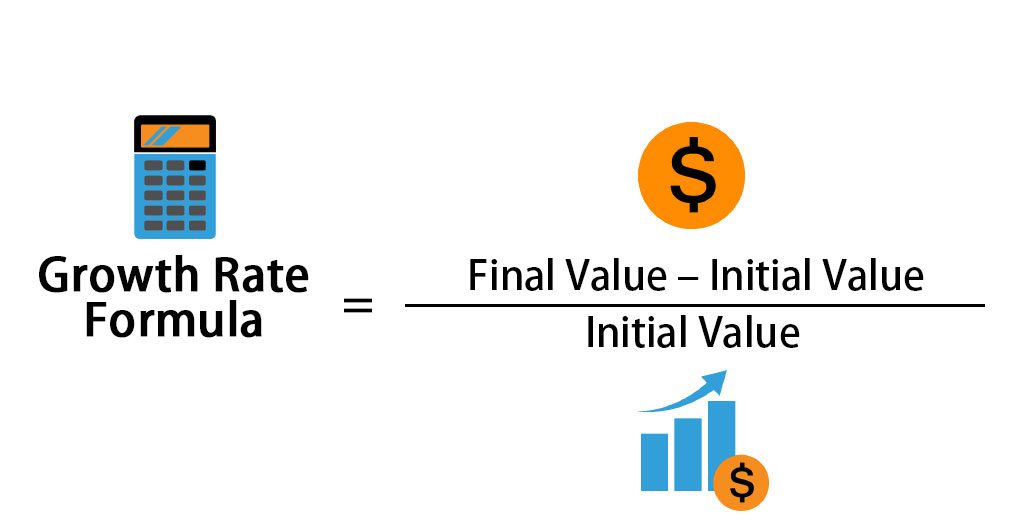

In [ ]:
# list of stock dataframes
list_df = [bac_df, aapl_df, ge_df, f_df, fb_df, msft_df, amd_df, mu_df, intc_df, csco_df]

# loop through the the list_df to find mini and maxi of each stocks 
mini = [df[df['date'] == df['date'].min()]['close'].values.item() for df in list_df]
maxi = [df[df['date'] == df['date'].max()]['close'].values.item() for df in list_df]

# find list of abosolute difference between both stock price
diff = np.array(maxi) - np.array(mini)

# find the percentage growth
growth = (diff/mini)*100
growth_list = growth.tolist()
co_name_list = [df['co_name'].unique()[0] for df in list_df]

# visualize the growth of the stocks
fig, ax = plt.subplots(figsize=(13,7))
ax.barh(y=co_name_list, width=growth_list, height=0.9, color=['#4bd659','#4bd659','#ed615c','#ed615c','#4bd659',
                                                             '#4bd659','#4bd659','#4bd659','#4bd659','#4bd659'],
       edgecolor='#713ae8')
for p in ax.patches:
    ax.annotate(f'{round(p.get_width(),2)}%', (p.get_width()+15, p.get_y() +0.3))
ax.set_xlabel('Percentage growth in stock price')
ax.set_ylabel('Name of companies')
ax.set_title("Growth in stock price over a period of 5 years")
plt.show()

**Observations**

- **We can observe that growth of stock 'Facebook' is the highest among all other 10 stocks over a period of 5 years**
- **It is very much self-explanotary that stocks of 'Ford Motors' and 'General Electric' has given negative return over a years of period.**

### <h1 style='background:#4bd659; border:0; border-radius: 10px; color:black'><right> Daily return of stock prices analysis </right></h1>

<a id='dr'></a>

### Daily return hypothesis test

- **In stock market, you will often hear that daily return of any stock price is 0% which means you will get zero return on your investment in one day.**
- **So let's prove the hypothesis by analysing top 10 most traded stocks and assesing their daily return distribution in this section**

- **H0: Daily return is zero**
- **Ha: Daily return is not zero**

- **We will prove this hypothesis as a one sample t-test as we know population mean but are not aware of std deviation. if p-value is greater than 0.05 than we can not reject the null hypothesis and if it is less than 0.05 than we have to reject the null hypothesis**

In [ ]:
# python's scipy.stats module has ttest_1samp method we allows to prove this hypothesis
result_dict = {}
for df in list_df:
    result = stats.ttest_1samp(df['daily return'], 0)
    result_dict[df['ticks'].unique()[0]] = result   
result_dict

- **From above results, we can learn that pvalues of stocks 'MSFT'.'INTC' and 'CSCO' are less than 0.05 so we can reject the null hypothesis and accept alternative hypothesis that is 'Daily return is not zero' while for other stocks we cannot reject null hypothesis.**

- **Stistically it proves that 7 out of 10 have daily return of zero percentage which is the most general case.**

In [ ]:
###### function to plot daily return and histogram of 10 stocks
def daily_return(df):
    
    # assign variables to annotation positions
    ave_x = df['date'].mean()
    y_max = df['daily return'].max()
    y_max_date = df[df['daily return'] == df['daily return'].max()]['date'].values
    dt = pd.to_datetime(y_max_date, '%Y%m%d%H%M%S')
    xb = dt.item().date()
    y_min = df['daily return'].min()
    y_mean = df['daily return'].mean()
    
    plt.figure(figsize=(13,6), facecolor='#4bd659')
    
    plt.subplot(121)
    plt.plot(df['date'], df['daily return'], color='#062e63')
    plt.axhline(y=df['daily return'].max(), color='green', ls='--')
    plt.axhline(y=df['daily return'].min(), color='red', ls='--')
    plt.xlabel('Date')
    plt.ylabel("Percentage return")
    plt.annotate(f"Min. daily return={round(df['daily return'].min(),2)}%", 
                xy=(ave_x,y_min),xytext=(ave_x,y_min),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    plt.annotate(f"Max. daily return={round(df['daily return'].max(),2)}%\nDate was={xb}", 
                xy=(ave_x,y_max),xytext=(ave_x,y_max-0.6),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db', alpha=0.7)
                 )
    plt.title(f"Daily return of stock {df['co_name'].unique()[0]}")
    
    plt.subplot(122)
    plt.hist(df['daily return'], density=True, color='#0f52a8')
    plt.xlabel('Histogram')
    plt.axvline(x=df['daily return'].mean(), color='yellow', ls='--')
    if df['ticks'].unique()[0] == 'AMD':
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%", 
                xy=(y_mean,0.10),xytext=(y_mean+2,0.10),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba', 
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    elif df['ticks'].unique()[0] == 'MU':
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%", 
                xy=(y_mean,0.12),xytext=(y_mean+1,0.12),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba', 
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    else:
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%", 
                xy=(y_mean,0.20),xytext=(y_mean+1,0.20),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba', 
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    plt.title(f"Histogram of stock price")
    
    plt.show()
    
# call the function with dataframe
daily_return(bac_df)
daily_return(aapl_df)
daily_return(ge_df)
daily_return(f_df)
daily_return(fb_df)
daily_return(msft_df)
daily_return(amd_df)
daily_return(mu_df)
daily_return(intc_df)
daily_return(csco_df)

# <h1 style='background:red; border:0; border-radius: 10px; color:black'><right> Technical analysis of stocks using candle stick charts and moving average </right></h1>
<a id='ta'></a>


### Technical analysis of stocks

- **An open-high-low-close chart (also OHLC) is a type of chart typically used to illustrate movements in the price of a financial instrument over time. Each vertical line on the chart shows the price range (the highest and lowest prices) over one unit of time, e.g., one day or one hour. Tick marks project from each side of the line indicating the opening price (e.g., for a daily bar chart this would be the starting price for that day) on the left, and the closing price for that time period on the right. The bars may be shown in different hues depending on whether prices rose or fell in that period.**

*source: Wikipedia*

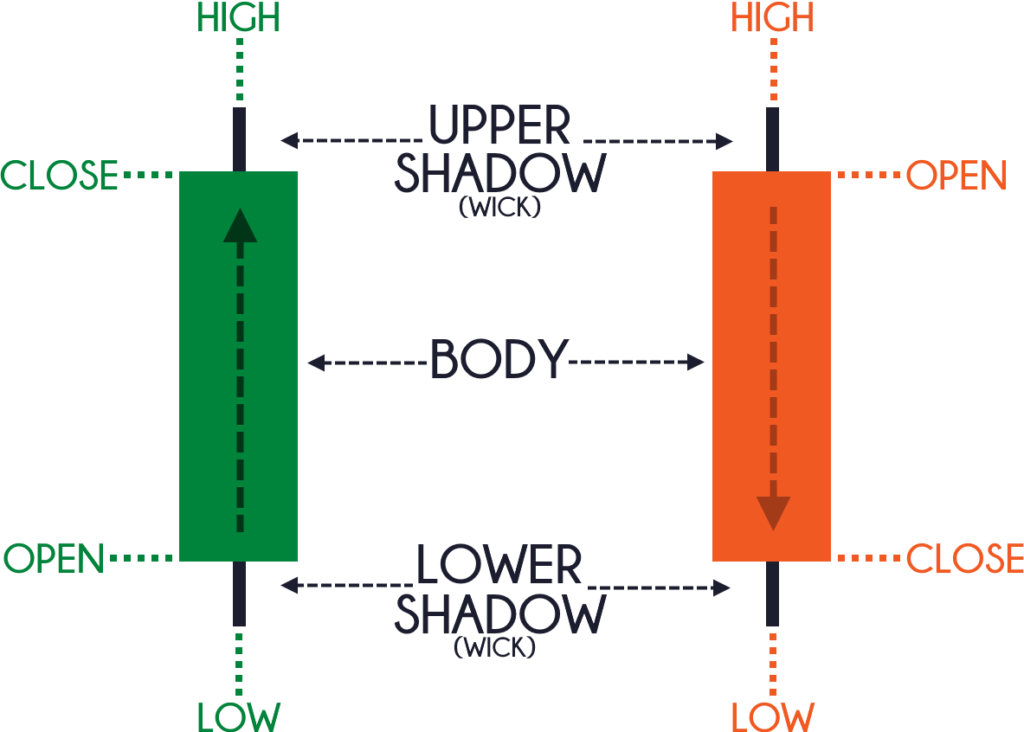

In [ ]:
# using matplotlib/mplfinance tool
F_df = f_df.copy()
F_df.set_index('date', inplace=True)
F_df
mpf.plot(F_df.iloc[:60,:], type='candle', mav=(5,7), figratio=(9,5))

### <h1 style='background:#4bd659; border:0; border-radius: 10px; color:black'><right> Candlestick charts of stocks to visualize OHLC prices </right></h1>
<a id='candle'></a>

In [ ]:
# using plotly graph_objs let's plot candlestick charts of stocks
def candlestick_chart(df):
    trace = go.Candlestick(x=df['date'],
                          open=df['open'],
                          high=df['high'],
                          low=df['low'],
                          close=df['close'])
    layout ={
    'title': f"{df['co_name'].unique()[0]} Historical Stock Price",
    'xaxis': {'title': 'Date'
             },
    'yaxis': {'title': 'Stock Price (USD$)'}
}
    
    
    data = [trace]
    
    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(xaxis_rangeslider_visible=False, paper_bgcolor='#4bd659')
    fig.show()
    
# plot the charts using this function
candlestick_chart(bac_df)
candlestick_chart(aapl_df)
candlestick_chart(ge_df)
candlestick_chart(f_df)
candlestick_chart(fb_df)
candlestick_chart(msft_df)
candlestick_chart(amd_df)
candlestick_chart(mu_df)
candlestick_chart(intc_df)
candlestick_chart(csco_df)

### <h1 style='background:#ed615c; border:0; border-radius: 10px; color:black'><right> Moving Averages charts of Facebook and Apple </right></h1>
<a id='mav'></a>

### Moving average of stocks

> A moving average (MA) is a stock indicator commonly used in technical analysis, used to help smooth out price data by creating a constantly updated average price. A rising moving average indicates that the security is in an uptrend, while a declining moving average indicates a downtrend. 

source: investopedia.com 

- **Moving average is one of the most widly used stock market forecasting method in finance industry, in this section we will plot and analyse stocks of 'FACEBOOK' and 'APPLE' using 10, 50 and 200 days moving averages to find uptrend and downtrends**


In [ ]:
# define function to return copies of stock dataframe with moving averages
def mav_function(df):
    
    # calclulate moving averages of 10,50 and 200 days
    df['10_d_avg'] = df['close'].rolling(window=10).mean()
    df['50_d_avg'] = df['close'].rolling(window=50).mean()
    df['200_d_avg'] = df['close'].rolling(window=200).mean()
    
    return df

# let's analyse apple and facebook stocks using moving averages methods
aapl_df = mav_function(aapl_df)
fb_df = mav_function(fb_df)

In [ ]:
# plot moving avearges charts of apple and facebook
aapl_dfn = aapl_df.copy()
fb_dfn = fb_df.copy()

def mav_chart(df):
    df = df.set_index('date')
    
    fig = tls.make_subplots(rows=2, cols=1, shared_xaxes=True)
    # set colors and cols names to be plotted
    colors = ['#ff4500', '#92a1cf', '#6E6E6E']
    avgs = ['10_d_avg','50_d_avg','200_d_avg']
    
    for col, c in zip(avgs, colors):
        fig.append_trace({'x': df.index, 'y': df[col], 'type': 'scatter', 'name': col, 'line': {'color': c}},1,1)
    for col in ['close']:
        fig.append_trace({'x': df.index, 'y': df[col], 'type': 'scatter', 'name': 'closing price', 'line': {'color': '#393f5e'}},2,1)
        
    fig['layout'].update(height=800,title=f"Relationship between Moving averages <br> and Closing Price of {df['co_name'].unique()[0]}",
                    paper_bgcolor='#4bd659', plot_bgcolor='#F2DFCE')
    fig.show()

## Moving average chart of 'FB'

In [ ]:
# plot the MAVs fo FB
mav_chart(fb_dfn)

**Analysis and Interpretation:**

- **From above stock chart of 'FB' we can observe that 14th Novemeber, 2016 is the first when 10 Days Moving avearge is going down than 50 Days Moving average which shows declining trends** 
- **On 4th January, 2017 10 Days Moving average starts moving above 200 Days Moving average which shows Upwards trend in 'FB' stock**
- **Over a period of 5 years FB showed upward trend except only one time which was around Dec. 2016, and reason of that decline was FB got into trouble by reports of 'Cambridge analytica Data scandle', thus stock declined in Dec. 2016**

## Moving average chart of 'AAPL'

In [ ]:
# plot the MAVs of Apple
mav_chart(aapl_dfn)

**Analysis and Interpretation:**

- **Apple's stock price shows more irregular fluctuations compared to FB with one major decline during period of 2015-16.**
- **Around 7th august 2015 10 Days Moving average of Apple's stock price goes below 200 Days Moving average which shows downward trend in apple's stock price.**
- **And exactly, year after 15th august 2016, 10 Days Moving average crosses 200 Days Moving avearge which show uptrend thereafter.**

- **By comparing stocks 'FB' and 'AAPL', we can conclude that 'FB' performed better than 'AAPL'. 'FB' showed more consistant growth as well as less fluctions than 'AAPL' which proves the performance of 'FB' stocks. My recommendation is to BUY 'FB' as it has great growth prospects.**



# <h1 style='background:green; border:0; border-radius: 10px; color:black'><right> Stock price forecasting: Modelling and forecast </right></h1>
<a id='forecast'></a>

### Forecasting Using Prophet
<a id='prop'></a>

> **Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.**
> 

source: https://facebook.github.io/prophet/

In [ ]:
# create function to return dataframe for forecating
def df_formatting(df):
    df = df.loc[:, ['date','close']]
    df.rename(columns={'date':'ds', 'close':'y'}, inplace=True)
    
    return df

aplph_df = df_formatting(aapl_df)
fbph_df = df_formatting(fb_df)

In [ ]:
# forecasting using prophet
def price_forecasting(df, period):
    
    prophet = Prophet(yearly_seasonality = 'auto')
    prophet.fit(df)
    future_price = prophet.make_future_dataframe(periods=period)
    forecasts = prophet.predict(future_price)
    forecast = forecasts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    
    # plot the foreasts
    fig = prophet.plot(forecasts)
    a = add_changepoints_to_plot(fig.gca(), prophet, forecasts)
    
    # plot the components 
    fig2 = prophet.plot_components(forecasts)
    
    return forecasts

### <h1 style='background:#ed615c; border:0; border-radius: 10px; color:black'><right> 'AAPL' stock price forecasting  </right></h1>

In [ ]:
forecast_aapl = price_forecasting(aplph_df, 365)

### <h1 style='background:#4bd659; border:0; border-radius: 10px; color:black'><right> 'FB' stock price forecasting </right></h1>

In [ ]:
forecast_fb = price_forecasting(fbph_df, 365)

### <h1 style='background:#ed615c; border:0; border-radius: 10px; color:black'><right> Forecasting using Auto-ARIMA models</right></h1>

<a id='arima'></a>

### Time-series decomposition

> **Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.**
> 

> **Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.**
> 

Source: machinelearningmastery.com


In [ ]:
# let's find seasonla decomposition of time-series models
def decomposition(df, period):
    # decompistion instance
    result_decom = seasonal_decompose(df['y'], model="additive", 
                                      period=period, extrapolate_trend='freq')
    # plot the componenets 
    fig = result_decom.plot()
    fig.set_size_inches((10, 6))
    # Tight layout to realign things
    fig.tight_layout()
    plt.show()
    
    # capture the compoenets 
    trend = result_decom.trend
    season = result_decom.seasonal
    reside = result_decom.resid
    return trend, season, reside

In [ ]:
# let's find compoenets for aapl stock price
tr, se, re = decomposition(aplph_df, 365)

In [ ]:
# let's find out components for fb stock price
ftr, fse, fre = decomposition(fbph_df, 365)

### Plot the autocorrelation and partial auto-correlation plots

In [ ]:
# function to retunr acf and pacf plots
def acf_pacf(df, lags):
    var = df['y']
    # plot the acf plot
    fig = plot_acf(var, lags=lags)
    fig.set_size_inches((9, 5))
    fig.tight_layout()
    plt.show()
    
    # plot the pacf plots
    fig = plot_pacf(var, lags=lags)
    fig.set_size_inches((9,5))
    fig.tight_layout()
    plt.show()

In [ ]:
# acf and pacf of aapl stock 
acf_pacf(aplph_df, 50)

In [ ]:
# acf and pacf plots of FB
acf_pacf(fbph_df, 50)

- **Auto-correlation interpretation - Slow decline in auto-correlation indicates time-series not stationary, we can prove the stationarity of time-series by Dicky-fuller test**

- **Partical auto-correlation interpretation - For both stocks PACF suggest that time-series dependence can be captured only 1 lag owing to its significance than other laged time-series**

### Dicky-Fuller Test(Stationarity test)

- **Hypothesis to prove dicky-fuller tests**

**H0 - Beta = 1 (the time-series is non-stationary)**

**HA - Beta < 1 (the time-series is stationary)**

In [ ]:
# funtion to return adfuller test results
def adfuller_test(df):
    adfuller_result = adfuller(df['y'], autolag='AIC')
    adfuller_output = pd.Series(adfuller_result[:4], index=['Test statistic', 'p-value',
                                                           'Lags Used','Number of Observations Used'])
    print(adfuller_output)

In [ ]:
print("adfuller test results for AAPLE")
adfuller_test(aplph_df)
print("----"*10)
print("adfuller test results for FB")
adfuller_test(fbph_df)

- **Both the stocks time-series is not stationary as p-values are much greater than 0.05, hence we cannot reject the null-hypothesis.**

### Finding degree of differencing

In [ ]:
# find degree of differencing 
def degree_of_differencing(df, co_name):
    company_ndiffs = ndiffs(df['y'], test = 'adf')
    print(f'The degree of differencing is {company_ndiffs} for {co_name}')
    
    return company_ndiffs

aapl_ddf = degree_of_differencing(aplph_df, 'APPLE')
fb_ddf = degree_of_differencing(fbph_df, 'Facebook')

### Train forecasting models using Auto-ARIMA

- **ARIMA stands for Auto Regessive Integrated Moving Average. The model's goal is to predict future securities or financial market moves by examining the differences between values in the series instead of through the actual values. An ARIMA model can be understood by outlining each of its components as follows:**

- **Auto Regression (AR):** Refers to a model that shows a changing variable that regresses on its own lagged or prior values.

- **Integrated (I):** Represents the differencing of raw observations to allow for the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values).

- **Moving Average (MA):** Incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.

In [ ]:
# funcrtion to split train and test time-series for modelling purpose
def arima_split(df, co_name):
    size = int(len(df)*0.95)
    train_df = (df['y'])[:size]
    test_df = (df['y'])[size:]
    
    print(f"data splits of company {co_name}")
    print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")
    print("-------------------------------")
    
    return train_df, test_df

apl_train, apl_test = arima_split(aplph_df, 'APPLE')
fb_train, fb_test = arima_split(fbph_df, 'FB')

In [ ]:
def find_best_fit_arima(df, co_name):
    print(f"Arima model for {co_name}")

    model = pm.auto_arima(df, test = 'adf', 
                          start_p = 1, start_q = 1,     
                          max_p = 3, max_q = 3,
                          d = None, seasonal = True,   
                          start_P = 0, m = 3,
                          trace = True, error_action = 'ignore',  
                          suppress_warnings = True, stepwise = True,
                          D = 1, information_criterion = 'aic')

    print(model.summary())
    print('\n')
    
    return model

model_apl = find_best_fit_arima(apl_train, 'APPLE')
model_fb = find_best_fit_arima(fb_train, 'FB')

In [ ]:
# let's plot forecasting models plots
def display_model_plots(model, co_name):
    plt.style.use('fivethirtyeight')
    model.plot_diagnostics(figsize = (20, 15));
    plt.suptitle(f'Model diagnostics of {co_name}', fontsize = 25)
    plt.subplots_adjust(top = 0.93)
    plt.show()
    plt.style.use('default')
    
display_model_plots(model_apl, 'AAPL')
print("-------"*20)
display_model_plots(model_fb, 'FB')

**Model diagnostics interpretation:**

**1) Standardized residual:** It is an error term of price forecating and actual price of stocks

**2) Histogram plus estimated density:** Histogram reresents normal distribution of errors, KDE plots and N(0,1) is notation of indicate mean is ZERO and variance of the distribution is ONE.

**3) Normal Q-Q:** Normal Q-Q plot implies normality of distribution as sample quantities mostly inline with theoretical quanitites. any deviation in such alignment would indicate distribution is skewed, or in layman terms error is either positive or negative side.

**4) Correlogram:** It simply indicates partial auto-correlation of time-series and shows which laged time-series is significant in forecasting actual time-series.

### Forecasting on test data and calculating RMSE

In [ ]:
def make_predictions_and_print_rmse(model, test_df, co_name):
    print(f"forecasting and RMSE of {co_name}")
    
    forecast, confidence_interval = model.predict(X=test_df, n_periods = len(test_df), return_conf_int = True)
    forecasts = pd.Series(forecast, index = test_df[:len(test_df)].index)
    lower = pd.Series(confidence_interval[:, 0], index = test_df[:len(test_df)].index)
    upper = pd.Series(confidence_interval[:, 1], index = test_df[:len(test_df)].index)
    
    rmse = np.sqrt(np.mean((forecast.values - test_df.values) ** 2))
    
    print("RMSE is: ", rmse)
    
    return forecasts, lower, upper

forecast, lower, upper = make_predictions_and_print_rmse(model_apl, apl_test, 'APPLE')
print("----------------------------")
forecastf, lowerf, upperf = make_predictions_and_print_rmse(model_fb, fb_test, 'FB')

# <h1 style='background:green; border:0; border-radius: 10px; color:black'><center> Conclusion </center></h1>


**1. In this notebook, we learned saw detailed analysis of time-series to find insights and findout best stocks among all the stocks** 

**2. We visualized stock prices and proved hypothesis of daily return of stocks**

**3. Finally, we built two different forecasting models usgin 'Prophet' and Auto-ARIMA' models to forecast future values of time-series**

**4. We found noth time-series being non-stationary and their degrees of differencing were 1.**